In [1]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
from interaction_inference import dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import tqdm

In [2]:
rng = np.random.default_rng()

In [3]:
def simulate_dataset_custom(name, interaction_values, gene_values, cells=1000, rate=1, runs=1, tqdm_disable=True):
    '''
    Custom dataset simulation
    '''

    # number of pairs
    gene_pairs = len(interaction_values) * len(gene_values) * runs

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # sample counter
    i = 0

    # for each sample
    for int_val in tqdm.tqdm(interaction_values, disable=tqdm_disable):
        for gene_val in gene_values:
            for k in range(runs):

                # Set reaction rate parameters
                k_on_1 = gene_val
                k_on_2 = gene_val
                k_off_1 = 1 - gene_val
                k_off_2 = 1 - gene_val
                k_tx_1 = rate
                k_tx_2 = rate
                k_deg_1 = 1
                k_deg_2 = 1
                k_reg = int_val

                # store parameters
                params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

                params = {
                    'k_on_1': k_on_1,
                    'k_on_2': k_on_2,
                    'k_off_1': k_off_1,
                    'k_off_2': k_off_2,
                    'k_tx_1': k_tx_1,
                    'k_tx_2': k_tx_2,
                    'k_deg_1': k_deg_1,
                    'k_deg_2': k_deg_2,
                    'k_reg': k_reg
                }

                # simulate sample from model
                sample = simulation.gillespie_telegraph(params, cells)

                # store counts
                counts_df.iloc[i] = sample

                # increment sample
                i += 1

    # construct dataset object
    data = dataset.Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = gene_pairs
    data.beta = np.array([1.0 for j in range(cells)])

    return data

In [4]:
# settings
gene_values = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]#[1.0, 0.75, 0.5, 0.25, 0.1]#[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
intr_values = [0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]#[0, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0] #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rate = 5
runs = 5

In [5]:
data = simulate_dataset_custom("data", intr_values, gene_values, cells=1000, rate=rate, runs=runs, tqdm_disable=False)

100%|██████████| 10/10 [16:15<00:00, 97.51s/it]


100%|██████████| 300/300 [00:08<00:00, 36.24it/s]


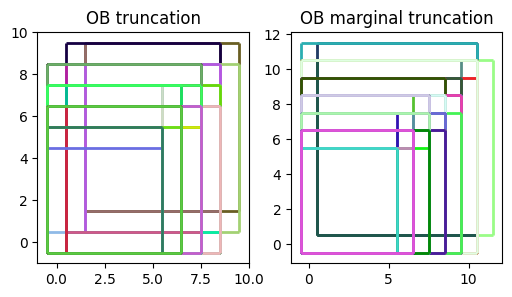

100%|██████████| 98/98 [00:00<00:00, 680.54it/s]


In [6]:
# pre-process
data.compute_moments(tqdm_disable=False)
data.compute_probabilities(tqdm_disable=False, display=True)

In [27]:
data.compute_fm(tqdm_disable=False)

100%|██████████| 300/300 [00:31<00:00,  9.67it/s]


In [7]:
# correlation
corr = correlation.Correlation(
    data,
    tqdm_disable=False,
    printing=False
)

100%|██████████| 300/300 [00:00<00:00, 659.25it/s]


In [ ]:
# moment dummy
momt_dummy = optimization.Optimization(
    data,
    ["dummy_moment"],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:06<00:00, 49.93it/s]


In [9]:
# moment
momt = optimization.Optimization(
    data,
    [
        "moment",
        "marginal_CME_1",
        "marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:06<00:00, 46.23it/s]


In [ ]:
# moment higher
momt_higher = optimization.Optimization(
    data,
    [
        "moment",
        "moment_higher"
        "marginal_CME_1",
        "marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:06<00:00, 46.54it/s]


In [11]:
# BD prob marginal
probM_BD = optimization.Optimization(
    data,
    [
        "marginal_probability_1",
        "marginal_probability_2",
        "marginal_CME_1",
        "marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:11<00:00, 27.15it/s]


In [12]:
# TE prob marginal
probM_TE = optimization.Optimization(
    data,
    [
        "marginal_probability_1",
        "marginal_probability_2",
        "marginal_CME_TE",
        "TE_equality",
        "k_deg_1",
        "k_deg_2"
    ],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:22<00:00, 13.35it/s]


In [13]:
# BD prob joint
probJ_BD = optimization.Optimization(
    data,
    [
        "probability",
        "marginal_CME_1",
        "marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:44<00:00,  6.76it/s]


In [ ]:
# TE prob joint
probJ_TE = optimization.Optimization(
    data,
    ["probability", "marginal_CME_TE", "TE_equality", "base"],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

'''
Too slow: most optimizations hit time limit
'''

  1%|▏         | 4/300 [05:00<9:45:01, 118.59s/it]

: 

: 

In [28]:
# Downsampled BD prob marginal
DprobM_BD = optimization.Optimization(
    data,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_1",
        "downsampled_marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False,
)

100%|██████████| 300/300 [00:13<00:00, 22.65it/s]


In [29]:
# Downsampled BD prob joint
DprobJ_BD = optimization.Optimization(
    data,
    [
        "downsampled_probability",
        "downsampled_CME",
        "k_deg_1",
        "k_deg_2",
        "k_reg"
    ],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [01:27<00:00,  3.43it/s]


In [37]:
def result_array(obj, corr_test=False):

    # arrays for result object
    res_array = np.zeros((len(intr_values), len(gene_values)))

    # sample counter
    i = 0

    # for each sample
    for j, _ in enumerate(intr_values):
        for k, _ in enumerate(gene_values):
            for l in range(runs):

                # get result
                if corr_test:
                    if obj.result_dict[i]['pvalue'] < 0.05:
                        res_array[j, k] += 1 / runs
                else:
                    if obj.result_dict[i]['status'] == "INFEASIBLE":
                        res_array[j, k] += 1 / runs

                # increment counter
                i += 1

    return res_array

In [14]:
# shape
shape = (len(intr_values), len(gene_values))

# arrays for result objects
corr_array = np.zeros(shape)
momt_array = np.zeros(shape)
probM_BD_array = np.zeros(shape)
probM_TE_array = np.zeros(shape)
probJ_BD_array = np.zeros(shape)
#probJ_TE_array = np.zeros(shape)

# sample counter
i = 0

# for each sample
for j, _ in enumerate(intr_values):
    for k, _ in enumerate(gene_values):
        for l in range(runs):

            # get result
            if corr.result_dict[i]['pvalue'] < 0.05:
                corr_array[j, k] += 1 / runs
            if momt.result_dict[i]['status'] == "INFEASIBLE":
                momt_array[j, k] += 1 / runs
            if probM_BD.result_dict[i]['status'] == "INFEASIBLE":
                probM_BD_array[j, k] += 1 / runs
            if probM_TE.result_dict[i]['status'] == "INFEASIBLE":
                probM_TE_array[j, k] += 1 / runs
            if probJ_BD.result_dict[i]['status'] == "INFEASIBLE":
                probJ_BD_array[j, k] += 1 / runs
            #if probJ_TE.result_dict[i]['status'] == "INFEASIBLE":
            #    probJ_TE_array[j, k] += 1 / runs

            # increment counter
            i += 1

In [38]:
def plot(result, title, caption, figsize=(6, 6), corr_test=False):

    # analyse
    array = result_array(result, corr_test=corr_test)

    fig, axs = plt.subplots(figsize=figsize)

    #fig.suptitle("Infeasibility %")

    #plt.tight_layout()

    cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

    vmin, vmax = 0, 1

    img = axs.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel("Gene on %")
    axs.set_xticks(range(len(gene_values)))
    axs.set_xticklabels(gene_values)
    axs.set_ylabel("Interaction strength")
    axs.set_yticks(range(len(intr_values)))
    axs.set_yticklabels(intr_values)
    axs.set_title(title)

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label(caption)

## Correlation

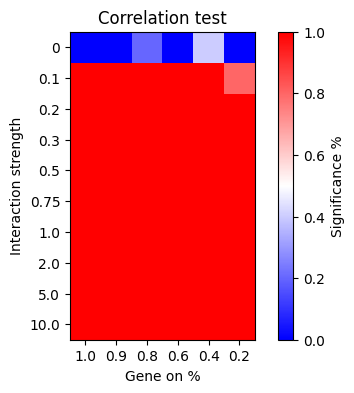

In [40]:
plot(corr, "Correlation test", "Significance %", figsize=(6, 4), corr_test=True)

## Moments

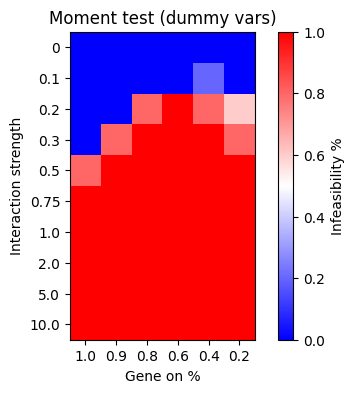

In [44]:
plot(momt_dummy, "Moment test (dummy vars)", "Infeasibility %", figsize=(6, 4))

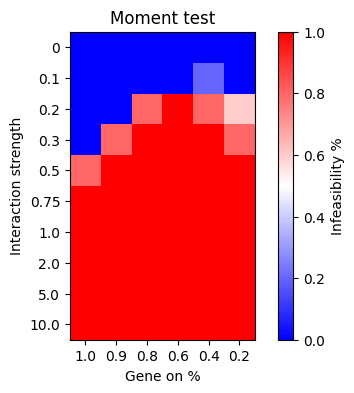

In [41]:
plot(momt, "Moment test", "Infeasibility %", figsize=(6, 4))

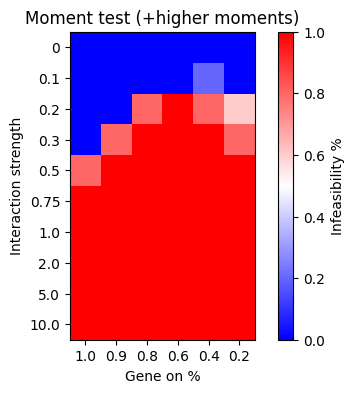

In [42]:
plot(momt_higher, "Moment test (+higher moments)", "Infeasibility %", figsize=(6, 4))

## B method probabilities

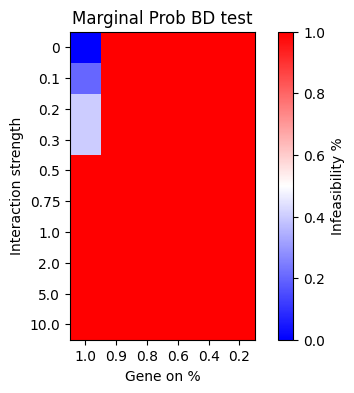

In [45]:
plot(probM_BD, "Marginal Prob BD test", "Infeasibility %", figsize=(6, 4))

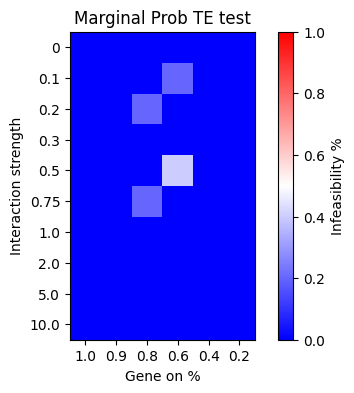

In [46]:
plot(probM_TE, "Marginal Prob TE test", "Infeasibility %", figsize=(6, 4))

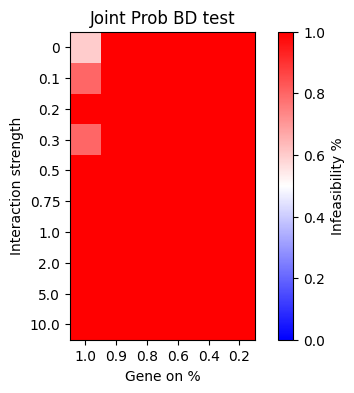

In [47]:
plot(probJ_BD, "Joint Prob BD test", "Infeasibility %", figsize=(6, 4))

## Downsampled probabilities

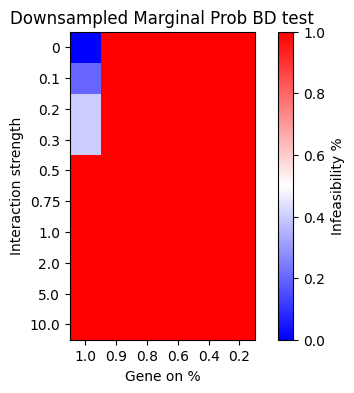

In [48]:
plot(DprobM_BD, "Downsampled Marginal Prob BD test", "Infeasibility %", figsize=(6, 4))

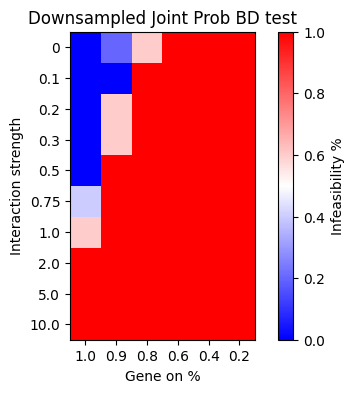

In [49]:
plot(DprobJ_BD, "Downsampled Joint Prob BD test", "Infeasibility %", figsize=(6, 4))

# Effect of observed threshold

In [42]:
from copy import deepcopy

In [43]:
data_thresh = deepcopy(data)

In [56]:
# smaller observed threshold
data_thresh.thresh_OB = 20
data_thresh.threshM_OB = 20

100%|██████████| 300/300 [00:07<00:00, 38.79it/s]


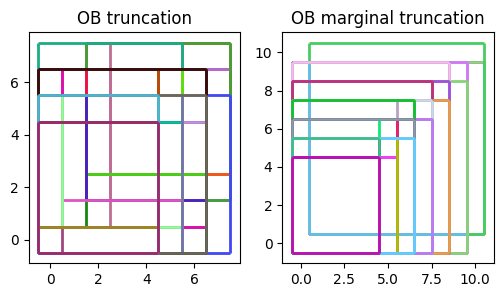

100%|██████████| 64/64 [00:00<00:00, 794.86it/s]


In [57]:
# pre-process
data_thresh.compute_moments(tqdm_disable=False)
data_thresh.compute_probabilities(tqdm_disable=False, display=True)

In [58]:
# BD prob marginal
probM_BD_thresh = optimization.Optimization(
    data_thresh,
    ["marginal_probability", "marginal_CME", "base"],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:13<00:00, 21.63it/s]


In [59]:
# TE prob marginal
probM_TE_thresh = optimization.Optimization(
    data_thresh,
    ["marginal_probability", "marginal_CME_TE", "TE_equality", "base"],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:45<00:00,  6.59it/s]


In [60]:
# BD prob joint
probJ_BD_thresh = optimization.Optimization(
    data_thresh,
    ["probability", "marginal_CME", "base"],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [00:32<00:00,  9.15it/s]


In [66]:
# TE prob joint
probJ_TE_thresh = optimization.Optimization(
    data_thresh,
    ["probability", "marginal_CME_TE", "TE_equality", "base"],
    license_file="C:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 300/300 [26:31<00:00,  5.31s/it]   


In [67]:
# shape
shape = (len(intr_values), len(gene_values))

# arrays for result objects
probM_BD_thresh_array = np.zeros(shape)
probM_TE_thresh_array = np.zeros(shape)
probJ_BD_thresh_array = np.zeros(shape)
probJ_TE_thresh_array = np.zeros(shape)

# sample counter
i = 0

# for each sample
for j, _ in enumerate(intr_values):
    for k, _ in enumerate(gene_values):
        for l in range(runs):

            # get result
            if probM_BD_thresh.result_dict[i]['status'] == "INFEASIBLE":
                probM_BD_thresh_array[j, k] += 1 / runs
            if probM_TE_thresh.result_dict[i]['status'] == "INFEASIBLE":
                probM_TE_thresh_array[j, k] += 1 / runs
            if probJ_BD_thresh.result_dict[i]['status'] == "INFEASIBLE":
                probJ_BD_thresh_array[j, k] += 1 / runs
            if probJ_TE_thresh.result_dict[i]['status'] == "INFEASIBLE":
                probJ_TE_thresh_array[j, k] += 1 / runs

            # increment counter
            i += 1

### Lower threshold (5)

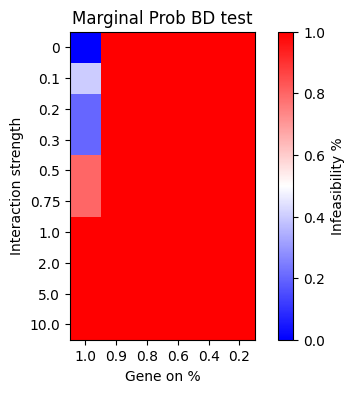

In [53]:
plot(probM_BD_thresh_array, "Marginal Prob BD test", "Infeasibility %", figsize=(6, 4))

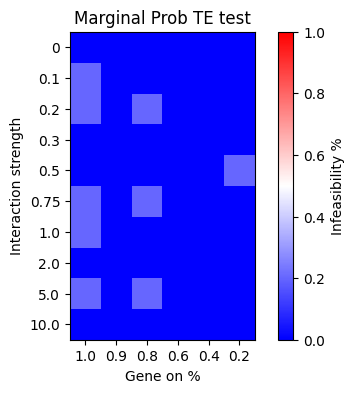

In [54]:
plot(probM_TE_thresh_array, "Marginal Prob TE test", "Infeasibility %", figsize=(6, 4))

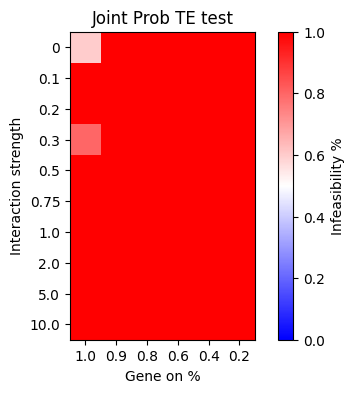

In [ ]:
plot(probJ_BD_thresh_array, "Joint Prob BD test", "Infeasibility %", figsize=(6, 4))
# wrong plot title

### Higher threshold (20)

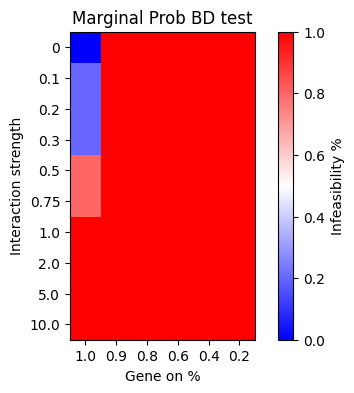

In [62]:
plot(probM_BD_thresh_array, "Marginal Prob BD test", "Infeasibility %", figsize=(6, 4))

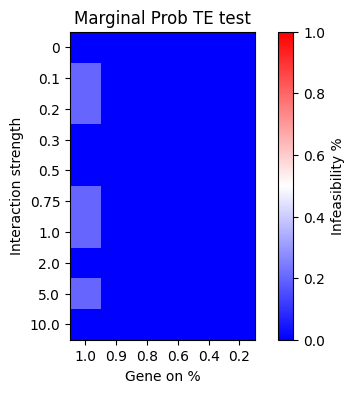

In [63]:
plot(probM_TE_thresh_array, "Marginal Prob TE test", "Infeasibility %", figsize=(6, 4))

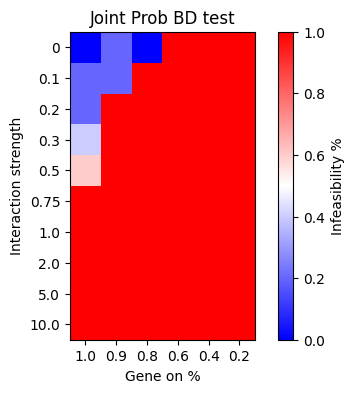

In [65]:
plot(probJ_BD_thresh_array, "Joint Prob BD test", "Infeasibility %", figsize=(6, 4))

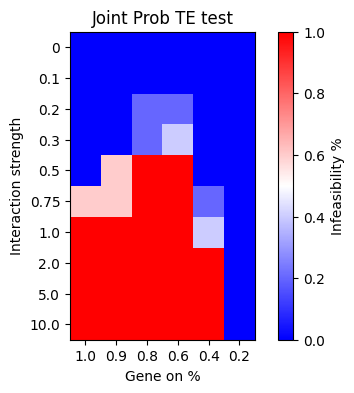

In [68]:
plot(probJ_TE_thresh_array, "Joint Prob TE test", "Infeasibility %", figsize=(6, 4))